In [1]:
import pathlib
import os
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer, TargetEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn import set_config
import xgboost as xgb
import optuna
import numpy as np
import shap

# Enable pandas output globally
set_config(transform_output="pandas")
variables_to_keep = None

In [2]:
# Get path to train file
train_path = os.path.join(pathlib.Path.cwd().parent, "raw", "train.csv")
test_path = os.path.join(pathlib.Path.cwd().parent, "raw", "test.csv")
train_path

'c:\\Users\\bogus\\Desktop\\Projects\\Kaggle competitions\\Introverts\\raw\\train.csv'

In [3]:
train_df = pd.read_csv(train_path, index_col=0)
# train_df, val_df = train_test_split(train_df, random_state=42)
test_df = pd.read_csv(test_path, index_col=0)
train_df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [4]:
numerical_vars = train_df.select_dtypes(include='number').columns.tolist()
categorical_vars = train_df.drop(labels="Personality", axis=1).select_dtypes(include='object').columns.tolist()
y_var = "Personality"
numerical_vars, categorical_vars, y_var

(['Time_spent_Alone',
  'Social_event_attendance',
  'Going_outside',
  'Friends_circle_size',
  'Post_frequency'],
 ['Stage_fear', 'Drained_after_socializing'],
 'Personality')

In [5]:
def divide_features(X):
    X = X.copy()
    for var1 in numerical_vars:
        for var2 in numerical_vars:
            if var1 != var2:
                X[f"{str(var1)}_by_{str(var2)}"] = X[var1] / (X[var2] + 1 + 1e-6)
    for var1 in numerical_vars:
        X[f"log_{var1}"] = np.log1p(X[var1])
    return X

In [6]:
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=-1)),
    # ("divide", FunctionTransformer(divide_features))
    # add more numeric transforms if needed
])

numerical_bins_enc = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=-1)),
    ("bins", KBinsDiscretizer(4, encode="ordinal")),
    ("target_enc", TargetEncoder())
])

numerical_bins = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=-1)),
    ("bins", KBinsDiscretizer(4, encode="onehot-dense")),
])

categorical_pipeline = Pipeline([
    # ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    # ("encoder", OrdinalEncoder()),
    ("target_enc", TargetEncoder())
    # ("encoder", OneHotEncoder(sparse_output=False, drop="first"))
])

preprocessing_pipeline = ColumnTransformer([
    ("numerical", numerical_pipeline, numerical_vars),
    ("categorical", categorical_pipeline, categorical_vars),
    ("missing_indicator", MissingIndicator(), numerical_vars),
    # ("bins_enc", numerical_bins_enc, numerical_vars),
    # ("bins", numerical_bins, numerical_vars)
])
# target_encoder_pipeline = Pipeline([
#     ("target_encoder", TargetEncoder())
# ])

# target_encoder_ct = ColumnTransformer([
#     ("target_encoding", target_encoder_pipeline, categorical_vars)  
#     ],
#                                       verbose_feature_names_out=False)
union_steps = [
    ("preprocessing", preprocessing_pipeline),
    # ("target_encoding", target_encoder_ct)
]


# Conditionally add drop transformer
if variables_to_keep:
    keep_transformer = ("keep", ColumnTransformer(
        transformers=[
            ("keep_features", "passthrough", variables_to_keep)
        ],
        remainder="drop",
        verbose_feature_names_out=False
    ))
    union_steps.append(keep_transformer)

pipeline = Pipeline(union_steps)

In [7]:
pipeline.fit(train_df, train_df[y_var])

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant'))]),
                                                  ['Time_spent_Alone',
                                                   'Social_event_attendance',
                                                   'Going_outside',
                                                   'Friends_circle_size',
                                                   'Post_frequency']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('target_enc',
                                                                   TargetEncoder())]),
                                                  ['Stage_fear',
                                                   'Drained_after_socializing']),
                                                 ('missing_indicator',
                                                  MissingIndicator(),
                                                  ['Time_spent_Alone',
                                                   'Social_event_attendance',
                                                   'Going_outside',
                                                   'Friends_circle_size',
                                                   'Post_frequency'])]))])

In [8]:
cleaned_df = pipeline.transform(train_df)
# cleaned_val_df = pipeline.transform(val_df)
cleaned_df.head()

,numerical__Time_spent_Alone,numerical__Social_event_attendance,numerical__Going_outside,numerical__Friends_circle_size,numerical__Post_frequency,categorical__Stage_fear,categorical__Drained_after_socializing,missing_indicator__missingindicator_Time_spent_Alone,missing_indicator__missingindicator_Social_event_attendance,missing_indicator__missingindicator_Going_outside,missing_indicator__missingindicator_Friends_circle_size,missing_indicator__missingindicator_Post_frequency
id,,,,,,,,,,,,
0,0.0,6.0,4.0,15.0,5.0,0.023398,0.023438,False,False,False,False,False
1,1.0,7.0,3.0,10.0,8.0,0.023398,0.023438,False,False,False,False,False
2,6.0,1.0,0.0,3.0,0.0,0.941274,0.597545,False,False,False,False,False
3,3.0,7.0,3.0,11.0,5.0,0.023398,0.023438,False,False,False,False,False
4,1.0,4.0,4.0,13.0,-1.0,0.023398,0.023438,False,False,False,False,True


In [9]:
dtrain = xgb.DMatrix(cleaned_df, train_df[y_var].map({"Extrovert": 1, "Introvert": 0}))
# dval = xgb.DMatrix(cleaned_val_df, val_df[y_var].map({"Extrovert": 1, "Introvert": 0}))

In [10]:
scale_pos_weight = sum(train_df[y_var] == "Introvert") / sum(train_df[y_var] == "Extrovert")

In [11]:
def objective(trial):
    scale_pos_weight = sum(train_df[y_var] == "Introvert") / sum(train_df[y_var] == "Extrovert")
    # Suggest hyperparameters
    scale_ind = trial.suggest_int("scale_ind", 0, 1)
    param = {
        "objective": "binary:logistic",
        "eval_metric": "error",  # accuracy = 1 - error
        "max_depth": trial.suggest_int("max_depth", 5, 100),
        "eta": trial.suggest_float("eta", 0.01, 0.3, log=True),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 100, log=True),
        "scale_pos_weight": scale_pos_weight * scale_ind + (1 - scale_ind)
    }
    # num_boost_round = trial.suggest_int("num_boost_round", 50, 1000)

    # Perform cross-validation
    cv_results = xgb.cv(
        params=param,
        dtrain=dtrain,
        num_boost_round=200,
        nfold=5,
        stratified=True,
        early_stopping_rounds=20,
        seed=42,
        verbose_eval=False
    )

    # Return best test error mean
    return cv_results["test-error-mean"].min()

# Create Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1000, n_jobs=4, gc_after_trial=True, show_progress_bar=True)

# Show best hyperparameters
print("Best params:", study.best_params)
print("Best test error:", study.best_value)

[I 2025-07-24 18:47:57,876] A new study created in memory with name: no-name-e8f80954-f237-46df-aab1-32b1d7adf791


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-07-24 18:47:58,521] Trial 1 finished with value: 0.2604729030584436 and parameters: {'scale_ind': 0, 'max_depth': 59, 'eta': 0.01610239400982648, 'gamma': 0.2850330821100777, 'subsample': 0.6603741411713437, 'colsample_bytree': 0.5024695316037302, 'lambda': 3.6520772111230007, 'alpha': 6.98515207653985, 'min_child_weight': 16}. Best is trial 1 with value: 0.2604729030584436.
[I 2025-07-24 18:47:59,002] Trial 3 finished with value: 0.03109470594579154 and parameters: {'scale_ind': 1, 'max_depth': 8, 'eta': 0.06424236173152116, 'gamma': 1.8657137808691022, 'subsample': 0.7985983022637573, 'colsample_bytree': 0.26250308102074404, 'lambda': 0.2003118285951355, 'alpha': 0.581007365977926, 'min_child_weight': 15}. Best is trial 3 with value: 0.03109470594579154.
[I 2025-07-24 18:47:59,463] Trial 4 finished with value: 0.2604729030584436 and parameters: {'scale_ind': 0, 'max_depth': 94, 'eta': 0.017502649670475455, 'gamma': 0.9947184446119661, 'subsample': 0.6965647042075096, 'colsamp

In [12]:
study.best_params

{'scale_ind': 0,
 'max_depth': 12,
 'eta': 0.1416330873687154,
 'gamma': 0.45502954788767447,
 'subsample': 0.8247899444599278,
 'colsample_bytree': 0.7764335354435093,
 'lambda': 1.2182708858496119,
 'alpha': 0.6422776959544358,
 'min_child_weight': 8}

In [13]:
final_params = study.best_params
final_params["scale_pos_weight"] = scale_pos_weight * final_params["scale_ind"] + (1 - final_params["scale_ind"])
bst = xgb.train(final_params, 
                num_boost_round=200, # study.best_params["num_boost_round"], 
                dtrain=dtrain)
preds = bst.predict(dtrain)
print(min(preds), max(preds))
print(sum((preds > 0.5) == train_df[y_var].map({"Extrovert": 1, "Introvert": 0})) / len(train_df))

C:\Users\bogus\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [19:02:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_ind" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


0.04239322 0.98319674
0.969445044266897


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

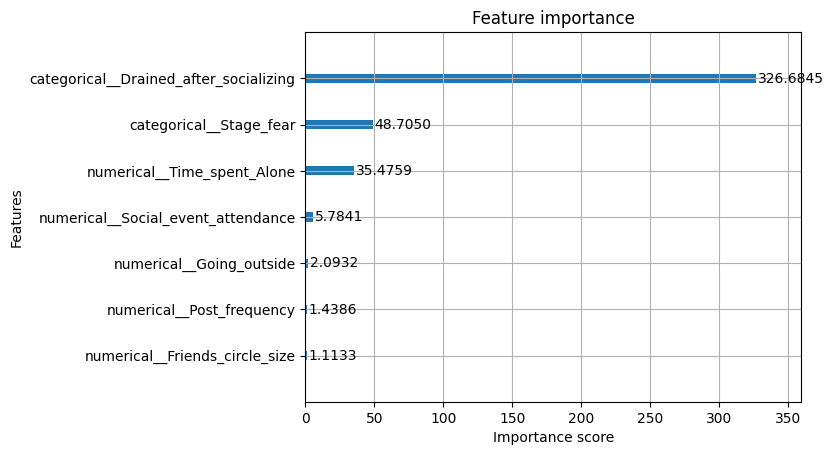

In [14]:
xgb.plot_importance(bst, importance_type='gain', max_num_features =100, values_format ="{v:.4f}")


C:\Users\bogus\AppData\Local\Temp\ipykernel_13188\2557668273.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, dtrain.get_data())


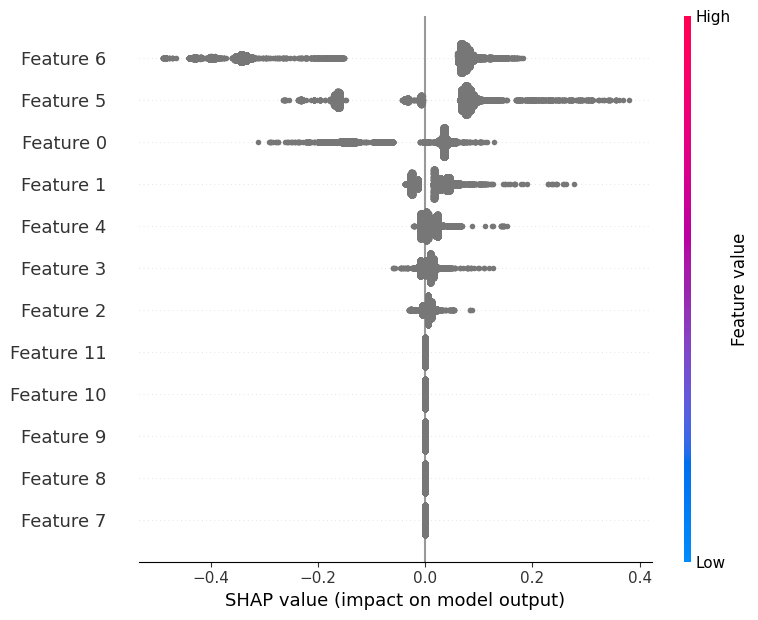

In [15]:
explainer = shap.Explainer(bst)
shap_values = explainer(dtrain.get_data())
shap.summary_plot(shap_values, dtrain.get_data())

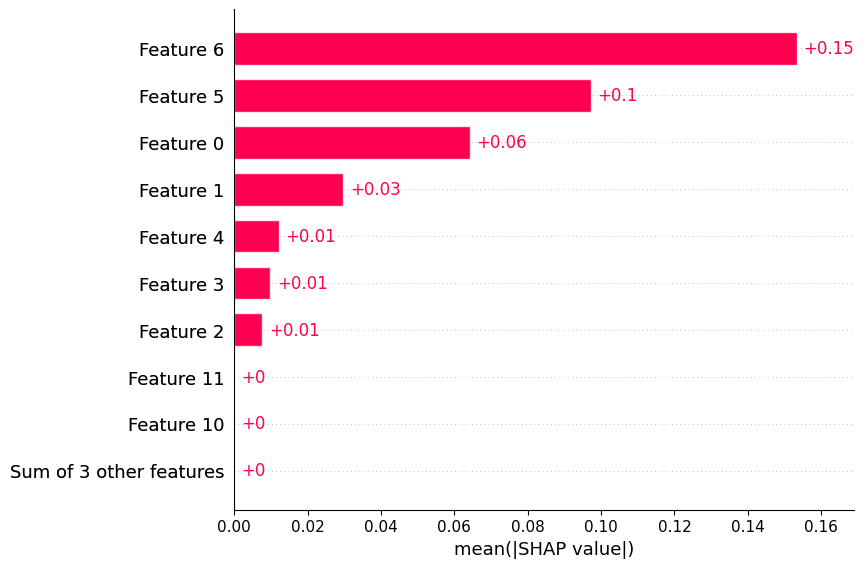

In [16]:
shap.plots.bar(shap_values)

In [17]:
limit = 2
variables_to_keep = [key for key, value in bst.get_score(importance_type="gain").items() if value > limit]
variables_to_keep

['numerical__Time_spent_Alone',
 'numerical__Social_event_attendance',
 'numerical__Going_outside',
 'categorical__Stage_fear',
 'categorical__Drained_after_socializing']

## Retrain on limited numbers of variables

In [18]:
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=-1)),
    # ("divide", FunctionTransformer(divide_features))
    # add more numeric transforms if needed
])

numerical_bins_enc = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=-1)),
    ("bins", KBinsDiscretizer(4, encode="ordinal")),
    ("target_enc", TargetEncoder())
])

numerical_bins = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=-1)),
    ("bins", KBinsDiscretizer(4, encode="onehot-dense")),
])

categorical_pipeline = Pipeline([
    # ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    # ("encoder", OrdinalEncoder()),
    ("target_enc", TargetEncoder()),
    # ("encoder", OneHotEncoder(sparse_output=False, drop="first"))
])

preprocessing_pipeline = ColumnTransformer([
    ("numerical", numerical_pipeline, numerical_vars),
    ("categorical", categorical_pipeline, categorical_vars),
    ("missing_indicator", MissingIndicator(), numerical_vars),
    # ("bins_enc", numerical_bins_enc, numerical_vars),
    # ("bins", numerical_bins, numerical_vars)
])
# target_encoder_pipeline = Pipeline([
#     ("target_encoder", TargetEncoder())
# ])

# target_encoder_ct = ColumnTransformer([
#     ("target_encoding", target_encoder_pipeline, categorical_vars)  
#     ],
#                                       verbose_feature_names_out=False)
union_steps = [
    ("preprocessing", preprocessing_pipeline),
    # ("target_encoding", target_encoder_ct)
]


# Conditionally add drop transformer
if variables_to_keep:
    keep_transformer = ("keep", ColumnTransformer(
        transformers=[
            ("keep_features", "passthrough", variables_to_keep)
        ],
        remainder="drop",
        verbose_feature_names_out=False
    ))
    union_steps.append(keep_transformer)

pipeline2 = Pipeline(union_steps)

In [19]:
pipeline2.fit(train_df, train_df[y_var])

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant'))]),
                                                  ['Time_spent_Alone',
                                                   'Social_event_attendance',
                                                   'Going_outside',
                                                   'Friends_circle_size',
                                                   'Post_frequency']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='con...
                                                   'Social_event_attendance',
                                                   'Going_outside',
                                                   'Friends_circle_size',
                                                   'Post_frequency'])])),
                ('keep',
                 ColumnTransformer(transformers=[('keep_features',
                                                  'passthrough',
                                                  ['numerical__Time_spent_Alone',
                                                   'numerical__Social_event_attendance',
                                                   'numerical__Going_outside',
                                                   'categorical__Stage_fear',
                                                   'categorical__Drained_after_socializing'])],
                                   verbose_feature_names_out=False))])

In [20]:
cleaned_df2 = pipeline2.transform(train_df)
# cleaned_val_df = pipeline.transform(val_df)
cleaned_df2.head()

,numerical__Time_spent_Alone,numerical__Social_event_attendance,numerical__Going_outside,categorical__Stage_fear,categorical__Drained_after_socializing
id,,,,,
0,0.0,6.0,4.0,0.023398,0.023438
1,1.0,7.0,3.0,0.023398,0.023438
2,6.0,1.0,0.0,0.941274,0.597545
3,3.0,7.0,3.0,0.023398,0.023438
4,1.0,4.0,4.0,0.023398,0.023438


In [21]:
dtrain2 = xgb.DMatrix(cleaned_df2, train_df[y_var].map({"Extrovert": 1, "Introvert": 0}))
# dval = xgb.DMatrix(cleaned_val_df, val_df[y_var].map({"Extrovert": 1, "Introvert": 0}))

In [22]:
def objective(trial):
    scale_pos_weight = sum(train_df[y_var] == "Introvert") / sum(train_df[y_var] == "Extrovert")
    # Suggest hyperparameters
    scale_ind = trial.suggest_int("scale_ind", 0, 1)
    param = {
        "objective": "binary:logistic",
        "eval_metric": "error",  # accuracy = 1 - error
        "max_depth": trial.suggest_int("max_depth", 5, 100),
        "eta": trial.suggest_float("eta", 0.01, 0.3, log=True),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 100, log=True),
        "scale_pos_weight": scale_pos_weight * scale_ind + (1 - scale_ind)
    }
    # num_boost_round = trial.suggest_int("num_boost_round", 50, 1000)

    # Perform cross-validation
    cv_results = xgb.cv(
        params=param,
        dtrain=dtrain2,
        num_boost_round=200,
        nfold=5,
        stratified=True,
        early_stopping_rounds=20,
        seed=42,
        verbose_eval=False
    )

    # Return best test error mean
    return cv_results["test-error-mean"].min()

# Create Optuna study
study2 = optuna.create_study(direction="minimize")
study2.optimize(objective, n_trials=100, n_jobs=4, gc_after_trial=True, show_progress_bar=True)

# Show best hyperparameters
print("Best params:", study2.best_params)
print("Best test error:", study2.best_value)

[I 2025-07-24 19:02:14,310] A new study created in memory with name: no-name-7236ae17-0886-4a4d-b304-6ab54c30e057


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-24 19:02:15,186] Trial 1 finished with value: 0.030824785838995228 and parameters: {'scale_ind': 1, 'max_depth': 14, 'eta': 0.13047830934806007, 'gamma': 4.056027653344719, 'subsample': 0.44859004830127297, 'colsample_bytree': 0.5098490714082251, 'lambda': 0.0022782993754045366, 'alpha': 0.5991779462004054, 'min_child_weight': 13}. Best is trial 1 with value: 0.030824785838995228.
[I 2025-07-24 19:02:15,190] Trial 0 finished with value: 0.030878752371875023 and parameters: {'scale_ind': 1, 'max_depth': 24, 'eta': 0.01544277200981334, 'gamma': 0.5790924263026487, 'subsample': 0.5779879694875625, 'colsample_bytree': 0.35033046124058737, 'lambda': 0.5643644984459886, 'alpha': 0.007219361309521992, 'min_child_weight': 33}. Best is trial 1 with value: 0.030824785838995228.
[I 2025-07-24 19:02:16,080] Trial 3 finished with value: 0.03120262443781825 and parameters: {'scale_ind': 0, 'max_depth': 84, 'eta': 0.035166587233071055, 'gamma': 0.32921322180725077, 'subsample': 0.683059176

In [23]:
final_params = study2.best_params
final_params["scale_pos_weight"] = scale_pos_weight * final_params["scale_ind"] + (1 - final_params["scale_ind"])
bst2 = xgb.train(final_params, 
                num_boost_round=200, # study.best_params["num_boost_round"], 
                dtrain=dtrain2)
preds = bst2.predict(dtrain2)
print(min(preds), max(preds))
print(sum((preds > 0.5) == train_df[y_var].map({"Extrovert": 1, "Introvert": 0})) / len(train_df))

-0.053621057 1.0140715
0.9690131721010581


C:\Users\bogus\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [19:03:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_ind" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Test predcition

In [27]:
test_transformed = pipeline.transform(test_df)
dtest = xgb.DMatrix(test_transformed)
y_pred_probs = bst.predict(dtest)
# y_pred_probs
test_predict = pd.DataFrame({"Prediction": y_pred_probs > 0.5}).astype(int)# .map({0: "Introvert", 1: "Extrovert"})
test_predict["Prediction"] = test_predict["Prediction"].map({0: "Introvert", 1: "Extrovert"})
test_predict

,Prediction
0,Extrovert
1,Introvert
2,Extrovert
3,Extrovert
4,Introvert
...,...
6170,Extrovert
6171,Introvert
6172,Extrovert
6173,Extrovert


In [28]:
write_df = pd.DataFrame(
    {
        "id": test_df.index,
        y_var: test_predict["Prediction"]
    }
)

In [29]:
write_df.to_csv("submission.csv", index=False)